In [1]:
!git clone https://github.com/Nikhil9786/Self-Driving-Car.git

Cloning into 'Self-Driving-Car'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 14966 (delta 0), reused 0 (delta 0), pack-reused 14963
Receiving objects: 100% (14966/14966), 203.73 MiB | 41.48 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Checking out files: 100% (14991/14991), done.


In [2]:
#importing required libraries
import numpy as np
import pandas as pd
import csv
from PIL import Image
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Cropping2D, Lambda, Dropout
from keras.losses import MSE
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

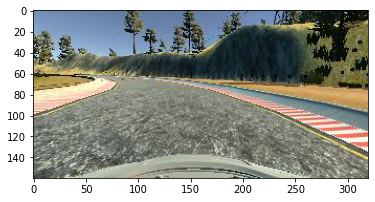

In [3]:
img = plt.imread('/content/Self-Driving-Car/IMG/center_2020_11_30_14_21_12_549.jpg')
plt.imshow(img)
plt.show()

In [4]:
# data preprocessing
car_images=[]
steering_angles=[]
count=0
with open('/content/Self-Driving-Car/driving_log.csv') as csvfile:
  reader = csv.reader(csvfile)
  for line in reader:
    steering_center = float(line[3])
    correction=0.2
    steering_left = steering_center + correction
    steering_right = steering_center - correction

    img_path = '/content/Self-Driving-Car/IMG/'
    line_0 = line[0].split('\\')[-1]
    line_1 = line[1].split('\\')[-1]
    line_2 = line[2].split('\\')[-1]
    img_center = np.asarray(Image.open(img_path + line_0))
    img_left = np.asarray(Image.open(img_path + line_1))
    img_right = np.asarray(Image.open(img_path + line_2))

    car_images.append(img_center)
    steering_angles.append(steering_center)

    car_images.append(img_left)
    steering_angles.append(steering_left)

    
    car_images.append(img_right)
    steering_angles.append(steering_right)

    del img_center,img_left,img_right,line_0,line_1,line_2,steering_center,steering_left,steering_right
    
print(len(car_images))
print(len(steering_angles))

5328
5328


In [5]:
# spliting data into training and testing using sklearn library
X_train,X_test,Y_train,Y_test = train_test_split(car_images,steering_angles,test_size=0.33,random_state=42)

In [6]:
print(X_train[0].shape)

(160, 320, 3)


In [7]:
# modified model
model  = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25),(0,0))))
model.add(Conv2D(24,(5,5),strides=(2,2),activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(36,(5,5),strides=(2,2),activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(48,(5,5),strides=(2,2),activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Flatten())

# NVIDIA Model
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d (Cropping2D)      (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 31, 158, 24)       1824      
_________________________________________________________________
dropout (Dropout)            (None, 31, 158, 24)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 77, 36)        21636     
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 77, 36)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 37, 48)         4

In [8]:
# Compiling using default lr of Adam Optimizer
model.compile(optimizer='adam', loss='mse')

In [9]:
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)

In [10]:
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True)
callbacks_list = [checkpoint]
training_model = model.fit(X_train,Y_train,
                          epochs=50,verbose=1,steps_per_epoch = len(X_train)//64,
                          validation_split=0.2,batch_size=64,validation_steps=int(len(X_train)*0.2/64)
                          )

Epoch 1/50
55/55 [==============================] - 1s 26ms/step - loss: 0.0694 - val_loss: 0.0642
Epoch 2/50
55/55 [==============================] - 1s 21ms/step - loss: 0.0576 - val_loss: 0.0579
Epoch 3/50
55/55 [==============================] - 1s 21ms/step - loss: 0.0524 - val_loss: 0.0553
Epoch 4/50
55/55 [==============================] - 1s 21ms/step - loss: 0.0537 - val_loss: 0.0562
Epoch 5/50
55/55 [==============================] - 1s 21ms/step - loss: 0.0486 - val_loss: 0.0538
Epoch 6/50
55/55 [==============================] - 1s 21ms/step - loss: 0.0479 - val_loss: 0.0521
Epoch 7/50
55/55 [==============================] - 1s 21ms/step - loss: 0.0494 - val_loss: 0.0527
Epoch 8/50
55/55 [==============================] - 1s 21ms/step - loss: 0.0478 - val_loss: 0.0535
Epoch 9/50
55/55 [==============================] - 1s 21ms/step - loss: 0.0466 - val_loss: 0.0508
Epoch 10/50
55/55 [==============================] - 1s 21ms/step - loss: 0.0481 - val_loss: 0.0492
Epoch 11/

In [11]:
model.save('./model.h5')

dict_keys(['loss', 'val_loss'])


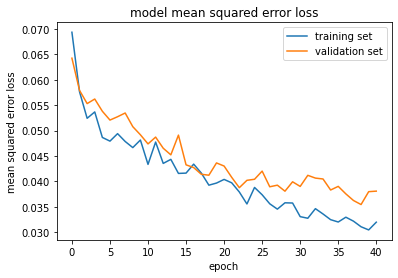

In [12]:
# Plotting
print(training_model.history.keys())
plt.plot(training_model.history['loss'])
plt.plot(training_model.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

Refrences:
1. https://naokishibuya.medium.com/introduction-to-udacity-self-driving-car-simulator-4d78198d301d
2. https://github.com/udacity/self-driving-car-sim
3. https://github.com/RamAIbot/Self_Driving_car_Behavioral_Cloning.git
4. https://github.com/naokishibuya/car-behavioral-cloning.git
5. https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf